In [ ]:
%pip install scikit-learn
%pip install pandas
%pip install matplotlib
%pip install keras-tuner

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime as dt

# Importing Keras components (using tensorflow.keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, SimpleRNN, Flatten
from tensorflow.keras.models import load_model  # for loading a saved model
import keras_tuner as kt

In [21]:
# 1. Data Preprocessing Functions

In [13]:
# Data Preprocessing Functions
def load_and_preprocess_data(csv_path):
    """
    Loads the dataset, selects valid columns, drops missing values,
    and scales the numerical features.
    """
    # Load dataset
    df = pd.read_csv(csv_path)
    print("Available columns:", df.columns.tolist())

    # Standardize column names: strip extra spaces and convert to lower-case
    df.columns = df.columns.str.strip().str.lower()
    
    # Convert 'date' to datetime if needed (we will use it only as an index/time reference)
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
    df.sort_values('date', inplace=True)
    
    # Create a normalized weekday feature:
    # Monday=0, Sunday=6 so normalized = weekday/6.
    df['weekday'] = df['date'].dt.weekday.astype(float) / 6.0


    last_date = df['date'].iloc[-30]  # store the last date for future forecasting
    
    #date	namespace	pods	cpu requested	cpu used	percentage of usage
    # Select numerical columns for forecasting.
    # We will use "pods", "cpu request", "cpu used", and "percentage"
    #df = df[['pods', 'cpu requested', 'cpu used', 'percentage of usage']]
    #df.dropna(inplace=True)
    
    #expected_cols = ['pods', 'cpu requested', 'cpu used', 'percentage of usage']
    expected_cols = ['cpu used', 'weekday']
    missing = [col for col in expected_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing expected columns: {missing}")
    
    #not exposing last 30 days of data for testing period
    df = df[df.date <= last_date]
    
    df = df[expected_cols].dropna() # drop any missing values
    
    # Scale the features to [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    
    return scaled_data, scaler, last_date

In [3]:
def create_sequences(data, lookback=10):
    """
    Creates sequences for time series forecasting.
    Each sequence is of length 'lookback' (e.g., 10 days); the target is the cpu used value of the next day.
    The feature vector for each day is assumed to be:
         [cpu used, weekday]
    We assume 'cpu used' is in column 0.
    Returns:
      X: array of shape (n_samples - lookback, lookback, 2)
      y: array of shape (n_samples - lookback,)
    """
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        #y.append(data[i+lookback, -1])  # last column is the target
        y.append(data[i + lookback, 0])  # target: cpu used (column index 0)

    return np.array(X), np.array(y)

In [ ]:
# 2. Model Building with Hyperparameter Tuning Functions

In [4]:
def build_lstm_model_tuner(hp, input_shape):
    """Builds an LSTM model with hyperparameter tuning."""
    model = Sequential()
    
    # Add explicit input layer.
    model.add(Input(shape=input_shape))
    
    # First LSTM layer with variable number of units
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(LSTM(lstm_units, return_sequences=True)) #, input_shape=input_shape
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer
    lstm_units2 = hp.Int('lstm_units2', min_value=32, max_value=128, step=32)
    model.add(LSTM(lstm_units2))
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
def build_bilstm_model_tuner(hp, input_shape):
    """Builds a Bidirectional LSTM model with hyperparameter tuning."""
    model = Sequential()
    
    # Add explicit input layer.
    model.add(Input(shape=input_shape))
    
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True))) #, input_shape=input_shape
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    
    lstm_units2 = hp.Int('lstm_units2', min_value=32, max_value=128, step=32)
    model.add(Bidirectional(LSTM(lstm_units2)))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
def build_hybrid_model_tuner(hp, input_shape):
    """Builds a Hybrid LSTM-RNN model with hyperparameter tuning."""
    model = Sequential()
    
    # Add explicit input layer.
    model.add(Input(shape=input_shape))
    
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(LSTM(lstm_units, return_sequences=True)) #, input_shape=input_shape
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    
    rnn_units = hp.Int('rnn_units', min_value=32, max_value=128, step=32)
    model.add(SimpleRNN(rnn_units))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [7]:
def build_lstm_ann_model_tuner(hp, input_shape):
    """
    Builds a LSTM-ANN model where LSTM layers extract temporal features
    followed by dense layers for regression.
    """
    model = Sequential()
    
    # Add explicit input layer.
    model.add(Input(shape=input_shape))

    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(LSTM(lstm_units, return_sequences=True)) #, input_shape=input_shape
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    
    lstm_units2 = hp.Int('lstm_units2', min_value=32, max_value=128, step=32)
    model.add(LSTM(lstm_units2))
    model.add(Dropout(dropout_rate))
    
    # ANN/Dense part
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# def build_lstm_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(0.2))
#     model.add(LSTM(50))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

In [ ]:
# def build_bilstm_model(input_shape):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(50)))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

In [ ]:
# def build_hybrid_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(0.2))
#     model.add(SimpleRNN(50))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

In [ ]:
# def build_ann_model(input_shape):
#     # For ANN, we flatten the input (i.e. sequence of data becomes a single vector)
#     model = Sequential()
#     model.add(Flatten(input_shape=input_shape))
#     model.add(Dense(50, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(50, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

In [22]:
# 3. Monte Carlo Dropout for Uncertainty Estimation

In [8]:
# Monte Carlo Dropout for Uncertainty Estimation
def predict_with_uncertainty(model, X, n_iter=100):
    """
    Uses Monte Carlo dropout to generate multiple predictions
    and compute the 95% confidence interval.
    Returns the prediction mean, lower bound, upper bound, and CI width.
    """
    # Run forward passes with dropout enabled (training=True)
    preds = np.array([model(X, training=True).numpy().flatten() for _ in range(n_iter)])
    prediction_mean = preds.mean(axis=0)
    prediction_std = preds.std(axis=0)
    
    z = 1.96  # corresponding to 95% confidence
    lower_bound = prediction_mean - z * prediction_std
    upper_bound = prediction_mean + z * prediction_std
    ci_width = upper_bound - lower_bound  # width of the CI

    return prediction_mean, lower_bound, upper_bound, ci_width

In [23]:
# 4. Model Training & Hyperparameter Tuning

In [9]:
def tune_and_evaluate(model_builder, model_name, X_train, y_train, X_val, y_val, input_shape, max_epochs=20, batch_size=32):
    """
    Uses Keras Tuner (Hyperband) to optimize hyperparameters for a given model architecture.
    Returns: Best model (trained on tuning data), its test RMSE, and average CI width.
    """
    tuner = kt.Hyperband(
        hypermodel=lambda hp: model_builder(hp, input_shape),
        objective="val_loss",
        max_epochs=max_epochs,
        factor=3,
        overwrite=True,
        directory="kt_dir", 
        project_name=model_name
    )
    
    tuner.search(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=max_epochs,
                 batch_size=batch_size,
                 verbose=0)
    
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hp)
    
    # Re-train the best model for sufficient epochs
    history = best_model.fit(X_train, y_train,
                             epochs=max_epochs,
                             batch_size=batch_size,
                             validation_data=(X_val, y_val),
                             verbose=0)
    
    # Evaluate performance on validation set
    predictions = best_model.predict(X_val).flatten()
    rmse = sqrt(mean_squared_error(y_val, predictions))
    
    # Compute CI using Monte Carlo dropout
    _, _, _, ci_width = predict_with_uncertainty(best_model, X_val, n_iter=100)
    avg_ci_width = np.mean(ci_width)
    
    print(f"{model_name} | RMSE: {rmse:.4f} | Avg. 95% CI width: {avg_ci_width:.4f}")
    return best_model, rmse, avg_ci_width

In [ ]:
# # Model Training & Evaluation
# def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
#     history = model.fit(X_train, y_train,
#                         epochs=epochs,
#                         batch_size=batch_size,
#                         validation_data=(X_test, y_test),
#                         verbose=0)
#     # Standard prediction (without dropout uncertainty)
#     predictions = model.predict(X_test).flatten()
#     print(y_test, predictions)
#     rmse = sqrt(mean_squared_error(y_test, predictions))
    
#     # Monte Carlo dropout predictions for uncertainty estimates
#     _, _, _, ci_width = predict_with_uncertainty(model, X_test, n_iter=100)
#     avg_ci_width = np.mean(ci_width)
    
#     return rmse, avg_ci_width, history

In [24]:
# 5. Iterative Forecasting Function for Future Steps

In [10]:
def forecast_future(model, last_sequence, n_steps, last_date):
    """
    Iteratively forecasts n_steps ahead.
    
    For each forecast day:
      - The model predicts the scaled "cpu used" based on the current sequence.
      - The new row is constructed with:
          * the predicted scaled "cpu used" value, and
          * the normalized weekday computed from the actual future date.
      - The input sequence is updated (dropping the oldest row, appending the new row).
      
    This function computes the future weekday on the fly to avoid any indexing errors.
    
    Parameters:
      model        : The trained forecasting model.
      last_sequence: NumPy array of shape (lookback, 2), the most recent input sequence.
      n_steps      : Number of future days to forecast.
      last_date    : The last date (as a pd.Timestamp) from the training data.
      
    Returns:
      forecast     : NumPy array of predicted (scaled) "cpu used" values.
      future_dates : List of corresponding future dates.
    """

    forecast = []
    current_seq = last_sequence.copy()  # shape: (lookback, num_features)
    
    # Precompute future weekdays
    future_weekdays = []
    future_dates = []

    for i in range(1, n_steps + 1):
        # Determine the next date and corresponding normalized weekday.
        next_date = last_date + pd.Timedelta(days=i)
        future_dates.append(next_date)
        weekday_norm = next_date.weekday() / 6.0  # Monday=0, Sunday=6 normalized

        # Predict the next day's "cpu used"
        pred = model.predict(np.expand_dims(current_seq, axis=0)).flatten()[0]
        forecast.append(pred)

        # Create a new row: [predicted cpu used, normalized weekday].
        new_row = np.array([pred, weekday_norm])

        # Update the current sequence (remove oldest row, append new_row).
        current_seq = np.vstack([current_seq[1:], new_row])

    #     future_weekdays.append(weekday_norm)
    # future_weekdays = np.array(future_weekdays)

    # for _ in range(n_steps):
    #     # Predict the next time step (scaled value for "percentage")
    #     pred = model.predict(np.expand_dims(current_seq, axis=0)).flatten()[0]
    #     forecast.append(pred)
    #     # Update the sequence: remove the oldest row and append a new row.
    #     # For new row, we copy the last row's features; update the target (last column) to 'pred'
    #     #new_row = np.copy(current_seq[-1])
    #     #new_row[-1] = pred
        
    #     # Create a new row: predicted cpu used and the known future weekday for that forecast day.
    #     new_row = np.array([pred, future_weekdays[i]])

    #     current_seq = np.vstack([current_seq[1:], new_row])
    return np.array(forecast), future_dates

In [25]:
# 6. Main Routine

In [ ]:
# # Main function tying everything together
# def main():
#     # Load and preprocess data
#     data_scaled, scaler = load_and_preprocess_data("./data/test-1_cpu_usage_data.csv")
    
#     # Create time series sequences with a lookback window of 10
#     lookback = 10
#     X, y = create_sequences(data_scaled, lookback)
    
#     # Split into 80% training and 20% testing
#     train_size = int(0.8 * len(X))
#     X_train, X_test = X[:train_size], X[train_size:]
#     y_train, y_test = y[:train_size], y[train_size:]
    
#     input_shape = X_train.shape[1:]  # (lookback, num_features)
    
#     # Build models: LSTM, Bi-LSTM, Hybrid LSTM-RNN, and ANN.
#     models = {
#         "LSTM": build_lstm_model(input_shape),
#         "Bi-LSTM": build_bilstm_model(input_shape),
#         "Hybrid LSTM-RNN": build_hybrid_model(input_shape),
#         "ANN": build_ann_model(input_shape)
#     }
    
#     results = {}  # to store RMSE and CI widths for every model
    
#     print("Training and evaluating models ...")
#     for name, model in models.items():
#         print(f"------ {name} ------")
#         rmse, avg_ci_width, _ = train_and_evaluate(model, X_train, y_train, X_test, y_test)
#         results[name] = {"RMSE": rmse, "Avg_CI_Width": avg_ci_width}
#         print(f"{name} -> RMSE: {rmse:.4f}, Avg. CI Width: {avg_ci_width:.4f}")
    
#     # Model selection: choose the model with the lowest RMSE and CI width < 1.
#     acceptable_models = {name: metrics for name, metrics in results.items() if metrics["Avg_CI_Width"] < 1}
#     if acceptable_models:
#         best_model_name = min(acceptable_models, key=lambda n: acceptable_models[n]["RMSE"])
#         print("\nBest model based on RMSE and CI width < 1: ", best_model_name)
#     else:
#         print("\nNo model produced a confidence interval width below 1. Please check data/scaling or adjust model architecture.")

#     # Optionally, plot RMSE and CI widths for visual comparison.
#     names = list(results.keys())
#     rmse_vals = [results[name]["RMSE"] for name in names]
#     ci_vals = [results[name]["Avg_CI_Width"] for name in names]
    
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.bar(names, rmse_vals, color='skyblue')
#     plt.ylabel("RMSE")
#     plt.title("Model RMSE Comparison")
    
#     plt.subplot(1, 2, 2)
#     plt.bar(names, ci_vals, color='salmon')
#     plt.ylabel("Avg 95% CI Width")
#     plt.title("Confidence Interval Width")
    
#     plt.tight_layout()
#     plt.show()

In [ ]:
def main(file_path):
    # 1. Load and preprocess the dataset.
    data_scaled, scaler, last_date = load_and_preprocess_data(file_path)
    # Data is assumed to have two columns: [cpu used, weekday]

    # 2. Create overlapping sequences (lookback=10 days).
    # Create sequences (lookback window of, say, 10 time steps)
    lookback = 10
    X, y = create_sequences(data_scaled, lookback)
    
    # 3. Split into training (80%) and validation (20% for tuning/evaluation).
    train_size = int(0.8 * len(X))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    
    input_shape = X_train.shape[1:]  # (lookback, num_features)
    
    # 4. Define dictionary of candidate model building functions (for tuning)
    model_builders = {
        "LSTM": build_lstm_model_tuner,
        "Bi-LSTM": build_bilstm_model_tuner,
        "Hybrid LSTM-RNN": build_hybrid_model_tuner,
        "LSTM-ANN": build_lstm_ann_model_tuner
    }
    
    results = {}
    
    print("Hyperparameter tuning for candidate models...")
    for name, builder in model_builders.items():
        print(f"--- Tuning {name} model ---")
        best_model, rmse, avg_ci = tune_and_evaluate(builder, name, X_train, y_train, X_val, y_val,
                                                       input_shape, max_epochs=20, batch_size=32)
        results[name] = {"rmse": rmse, "avg_ci": avg_ci, "model": best_model}
    
    # 5. Select the best model: lowest RMSE among those with avg CI width (< 1)
    acceptable = {n: r for n, r in results.items() if r["avg_ci"] < 1}
    if not acceptable:
        print("No model meets the condition of average CI width < 1. Please re-check scaling or tuning range.")
        return
    best_model_name = min(acceptable, key=lambda n: acceptable[n]["rmse"])
    best_model = acceptable[best_model_name]["model"]
    print(f"\nBest model selected: {best_model_name} with RMSE: {acceptable[best_model_name]['rmse']:.4f}" )
    
    # 6. Save the best model to disk.
    model_path = "./models/best_cpu_model.h5"
    best_model.save(model_path)
    print(f"Best model saved to {model_path}.")

    # 7. Load the model from disk for forecasting.
    # loaded_model = tf.keras.models.load_model(model_path)
    loaded_model = load_model(model_path)
    print("Model loaded from disk. Proceeding to forecast.")
    
    # ----------------------------
    # 8. Forecast the next 30 days of CPU utilization using the best model
    # ----------------------------
    
    # We take the last available window from our entire dataset.
    last_sequence = X[-1]  # shape: (lookback, num_features)
    n_steps = 30
    #future_forecast_scaled = forecast_future(best_model, last_sequence, n_steps)
    forecast_scaled, future_dates = forecast_future(loaded_model, last_sequence, n_steps, last_date)
    
    # 9. Inverse-transform the forecast for "cpu used". Since "cpu used" is in column index 0.
    # NOTE: Our scaler was applied to all columns.  We assume 'cpu used' is the last column.
    percentage_index = 0  # index for "cpu used" (0: cpu used, 1: weekday)
    target_min = scaler.data_min_[percentage_index]
    target_max = scaler.data_max_[percentage_index]
    #future_forecast = future_forecast_scaled * (target_max - target_min) + target_min
    forecast_cpu_used = forecast_scaled * (target_max - target_min) + target_min
    
    # Create a DataFrame for forecasted values
    forecasted_df = pd.DataFrame({
        "date": future_dates,
        "forecasted_cpu_used": forecast_cpu_used
    })
    
    #save forecasted values
    forecasted_df.to_csv("./forecast/forcasted_cpu_utilization.csv", index=False)
    
    # Merge the original data with the forecast DataFrame for comparison
    # comparison_df = pd.merge(df_original, forecasted_df, on="date", how="outer")
    # Optionally, save this comparison to a CSV file
    # comparison_df.to_csv("cpu_utilization_comparison.csv", index=False)

    # 10. Plot the forecasted future values for 30-days
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_steps + 1), forecast_cpu_used, marker='o', label="Forecast CPU Used")
    plt.title("Forecast for Next 30 Days of CPU Utilization")
    plt.xlabel("Days Ahead")
    plt.ylabel("CPU Used")
    plt.legend()
    plt.show()

Available columns: ['date', 'namespace', 'pods', 'cpu requested', 'cpu used', 'percentage of usage']
Hyperparameter tuning for candidate models...
--- Tuning LSTM model ---


c:\Users\Uttam Kumar\Learning\Time-series\codebase\lstm-venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
LSTM | RMSE: 0.2055 | Avg. 95% CI width: 0.2003
--- Tuning Bi-LSTM model ---


c:\Users\Uttam Kumar\Learning\Time-series\codebase\lstm-venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Bi-LSTM | RMSE: 0.1995 | Avg. 95% CI width: 0.1932
--- Tuning Hybrid LSTM-RNN model ---


c:\Users\Uttam Kumar\Learning\Time-series\codebase\lstm-venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Hybrid LSTM-RNN | RMSE: 0.1968 | Avg. 95% CI width: 0.2941
--- Tuning LSTM-ANN model ---


c:\Users\Uttam Kumar\Learning\Time-series\codebase\lstm-venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


LSTM-ANN | RMSE: 0.2013 | Avg. 95% CI width: 0.3477

Best model selected: Hybrid LSTM-RNN with RMSE: 0.1968
Best model saved to ./models/best_cpu_model.h5.
Model loaded from disk. Proceeding to forecast.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

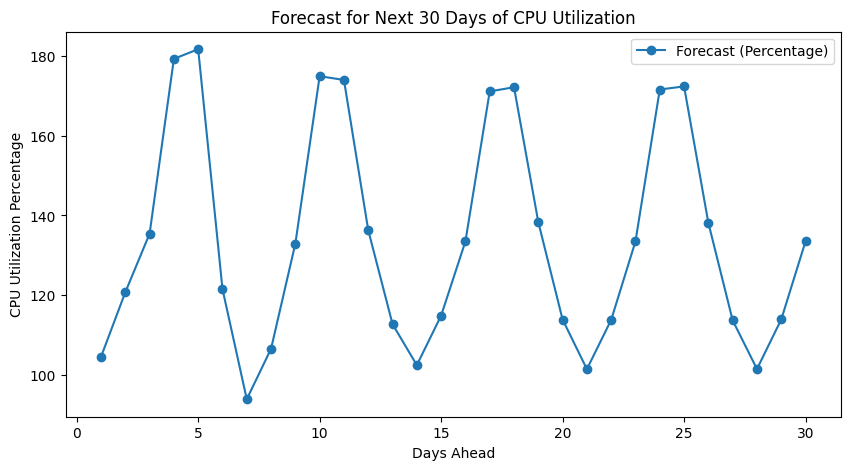

In [ ]:
if __name__ == "__main__":
    main("./data/test-1_cpu_usage_data.csv")

Available columns: ['date', 'namespace', 'pods', 'cpu requested', 'cpu used', 'percentage of usage']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

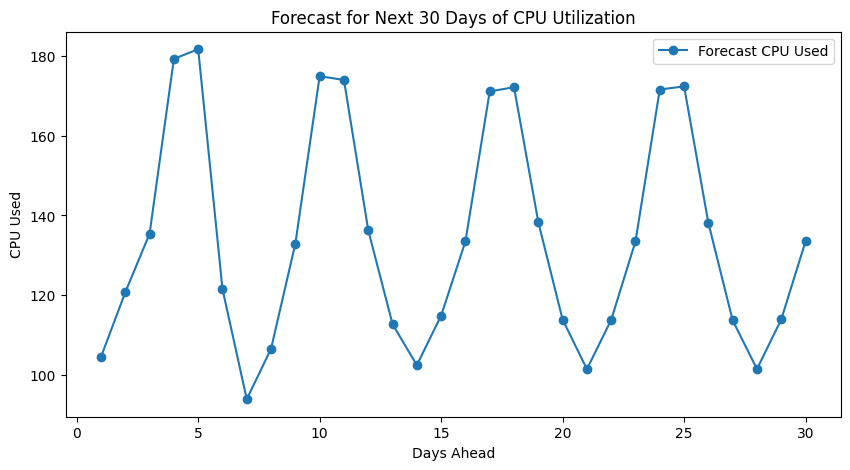

In [16]:
data_scaled, scaler, last_date = load_and_preprocess_data("./data/test-1_cpu_usage_data.csv")
lookback = 10
X, y = create_sequences(data_scaled, lookback)
model_path = "./models/best_cpu_model.h5"
loaded_model = load_model(model_path)
last_sequence = X[-1]  # shape: (lookback, num_features)
n_steps = 30
#future_forecast_scaled = forecast_future(best_model, last_sequence, n_steps)
forecast_scaled, future_dates = forecast_future(loaded_model, last_sequence, n_steps, last_date)
percentage_index = 0  # index for "cpu used" (0: cpu used, 1: weekday)
target_min = scaler.data_min_[percentage_index]
target_max = scaler.data_max_[percentage_index]
#future_forecast = future_forecast_scaled * (target_max - target_min) + target_min
forecast_cpu_used = forecast_scaled * (target_max - target_min) + target_min

# Create a DataFrame for forecasted values
forecasted_df = pd.DataFrame({
        "date": future_dates,
        "forecasted_cpu_used": forecast_cpu_used
    })
    
#save forecasted values
forecasted_df.to_csv("./forecast/forcasted_cpu_utilization.csv", index=False)

# 10. Plot the forecasted future values for 30-days
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_steps + 1), forecast_cpu_used, marker='o', label="Forecast CPU Used")
plt.title("Forecast for Next 30 Days of CPU Utilization")
plt.xlabel("Days Ahead")
plt.ylabel("CPU Used")
plt.legend()
plt.show()

In [17]:
forecasted_data = pd.read_csv("./forecast/forcasted_cpu_utilization.csv")

In [31]:
forecasted_data['date'] = pd.to_datetime(forecasted_data['date'])

In [33]:
forecasted_data.head()

,date,forecasted_cpu_used
0,2025-02-06,104.536323
1,2025-02-07,120.746153
2,2025-02-08,135.417336
3,2025-02-09,179.271505
4,2025-02-10,181.682384


In [34]:
orig_data = pd.read_csv("./data/test-1_cpu_usage_data.csv")
# Standardize column names: strip extra spaces and convert to lower-case
orig_data.columns = orig_data.columns.str.strip().str.lower()
    
# Convert 'date' to datetime if needed (we will use it only as an index/time reference)
orig_data['date'] = pd.to_datetime(orig_data['date'], format='%d-%m-%Y')
orig_data.sort_values('date', inplace=True)

In [36]:
orig_data.drop(['namespace', 'pods', 'cpu requested', 'percentage of usage'], axis=1, inplace=True)

In [37]:
orig_data.head()

,date,cpu used
0,2024-09-07,91.9
1,2024-09-08,245.7
2,2024-09-09,151.2
3,2024-09-10,144.2
4,2024-09-11,58.9


In [38]:
comparison_df = pd.merge(orig_data, forecasted_data, on="date", how="outer")

In [40]:
comparison_df.tail(35)

,date,cpu used,forecasted_cpu_used
147,2025-02-01,146.8,NaN
148,2025-02-02,112.7,NaN
149,2025-02-03,201.2,NaN
150,2025-02-04,49.7,NaN
151,2025-02-05,105.4,NaN
152,2025-02-06,140.0,104.536323
153,2025-02-07,146.2,120.746153
154,2025-02-08,205.1,135.417336
155,2025-02-09,296.8,179.271505
156,2025-02-10,106.0,181.682384


In [42]:
comparison_df.set_index('date', inplace=True)

<Axes: xlabel='date'>

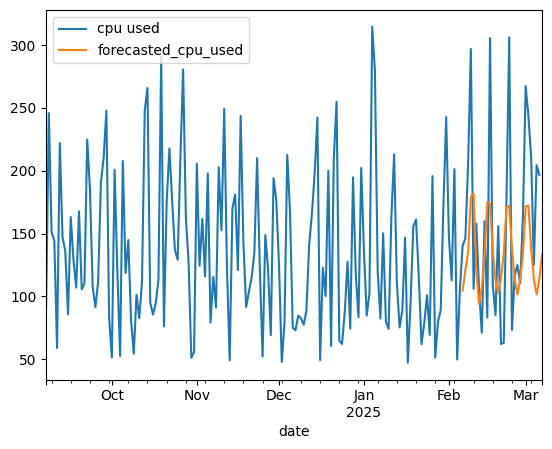

In [43]:
comparison_df.plot()

In [44]:
df_test = comparison_df.dropna()

In [45]:
df_test.head()

,cpu used,forecasted_cpu_used
date,,
2025-02-06,140.0,104.536323
2025-02-07,146.2,120.746153
2025-02-08,205.1,135.417336
2025-02-09,296.8,179.271505
2025-02-10,106.0,181.682384


In [46]:
np.sqrt(mean_squared_error(df_test['cpu used'],df_test['forecasted_cpu_used']))

np.float64(66.514339821423)